In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms as T

from src.scripts import SupervisedMidasDataset
from src.supervised import get_midas_env
from src.supervised import RMSELoss, RMSLELoss

In [3]:
# Enable device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [2]:
model, transforms = get_midas_env("MiDaS_small")

Using cache found in /home/rafa/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/rafa/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/rafa/.cache/torch/hub/intel-isl_MiDaS_master


In [4]:
batch_size = 16
train_size = 0.7
val_size = 0.2
dataset = SupervisedMidasDataset(data_path='/home/rafa/Documents/internship_summer/datasets/2020', transform=transforms)
# For the supervised approach we use random split. This won't be the case for the unsupervised approach
# because it uses the relation between sequences to calculate the loss
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, 1-train_size-val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)


In [5]:

def train_epoch(network, device, dataloader, optimizer, loss_function, print_every = 2):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    network.to(device)
    train_losses = []
    
    for i, data in enumerate(dataloader):   
      
      image, depth_map = data
      #Moving to GPU
      image = image.to(device)

      image = image.squeeze(1)
      depth_map = depth_map.to(device)
      # Sets the gradients attached to the parameters objects to zero.
      optimizer.zero_grad()  
      #Going through the network

      pred = network(image)
    


      pred = torch.nn.functional.interpolate(
          pred.unsqueeze(1),
          size=depth_map.shape[-2:],
          mode="bicubic",
          align_corners=False,
      ).squeeze()

      # Compute loss
      loss=loss_function(pred.squeeze(),  depth_map).float()
      
      # Backward pass

      loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
      optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
      
      # Print and store batch loss
      #batch_loss = loss.item()/depth_map.shape[0]
      train_losses.append(loss)
        
        #Display
      if i%print_every == 0:
          print(f'\t partial train loss (single batch): {loss}')
    return train_losses

In [6]:
def validation_epoch(network, device, loss_function, dataloader, print_every = 2):
    "Set evaluation mode for encoder and decoder"
    network.to(device)
    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for i, data in enumerate(dataloader):
            image, depth_map = data

            #Moving to GPU
            image = image.to(device)
            depth_map= depth_map.to(device)

            image = image.squeeze(1)
            #Applying the necessary transforms
            #(transform_midas does not keep the transformations in memory of the dataloader.)
            #Best= apply it the the entire dataset in its definition


            #Going through the network
            pred = network(image)

            pred = torch.nn.functional.interpolate(
                pred.unsqueeze(1),
                size=depth_map.shape[-2:],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
            #Computing the loss, storing it
            #d_test=T.functional.resize(d, (128, 256))
            loss=loss_function(pred,  depth_map).float()
            val_loss += loss.item()
            #Display
            if i%print_every == 0:
                print(f'\t partial validation loss (single batch): {loss}')
    return val_loss/len(dataloader)

In [7]:
## Training and Validation processes


## Choice of different parameters
lr=1e-3
weight_decay=1e-4 #Weight regularization to avoid overfitting
number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)
num_epochs= 2
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

## Choice of the loss
mse=nn.MSELoss()
l1=nn.L1Loss()
rmse=RMSELoss()
rmsle=RMSLELoss()


train_losses = []
rmse_metrics=np.array([])
rmsle_metrics=np.array([])
val_losses = []


## Training process

for epoch in range(num_epochs):
   train_losses_epoch= train_epoch(model, device, train_loader,optim, l1, print_every=2)
   val_loss_epoch = validation_epoch(model, device, mse, val_loader)
   train_losses.append(train_losses_epoch)
   val_losses.append(val_loss_epoch)

   #val_losses = np.append(val_losses, val_loss_epoch)
   
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses[epoch]} \t val loss {val_losses[epoch]}')# \t RMSE {rmse_metrics_epoch[-1]:.3f} \t RMSLE {rmsle_metrics_epoch[-1]:.3f}')

   #Plotting reconstruction results at the end of each epoch to see the evolution


	 partial train loss (single batch): 231.26669311523438
	 partial train loss (single batch): 10.979881286621094
	 partial train loss (single batch): 16.869110107421875
	 partial train loss (single batch): 17.965978622436523
	 partial train loss (single batch): 17.67084312438965
	 partial train loss (single batch): 13.366798400878906
	 partial train loss (single batch): 12.940788269042969
	 partial train loss (single batch): 15.959531784057617
	 partial train loss (single batch): 14.217476844787598
	 partial train loss (single batch): 13.757804870605469
	 partial train loss (single batch): 17.843172073364258
	 partial train loss (single batch): 13.770759582519531
	 partial train loss (single batch): 20.057838439941406
	 partial train loss (single batch): 12.069009780883789
	 partial train loss (single batch): 16.132402420043945
	 partial train loss (single batch): 15.601095199584961
	 partial train loss (single batch): 11.54520034790039
	 partial train loss (single batch): 18.7448749542

KeyboardInterrupt: 

In [30]:
image, depth = next(iter(train_loader))

In [5]:
image, depth = next(iter(train_loader))

In [6]:
print(image.shape)

torch.Size([16, 1, 3, 384, 672])


In [28]:
img = train_set[1500][0]
depth = train_set[1500][1]
print(img.shape)
print(depth.shape)
#input_batch = transforms(img).to(device)

torch.Size([1, 3, 384, 672])
(1057, 1881)


In [29]:
model.to(device)
img = img.cuda()
print(img.is_cuda)
with torch.no_grad():
    prediction = model(img)
    print(prediction.shape)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=depth.shape,
        mode="bicubic",
        align_corners=False,
    ).squeeze()
print(prediction.shape)
output = prediction.cpu().numpy()
print(output.shape)

True
torch.Size([1, 384, 672])
torch.Size([1057, 1881])
(1057, 1881)


(1057, 1881)


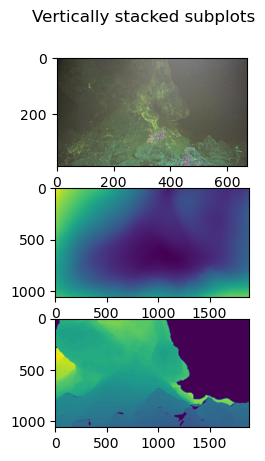

In [30]:
print(output.shape)
figs, axs = plt.subplots(3, 1)
figs.suptitle('Vertically stacked subplots')
axs[0].imshow((img.squeeze(0).permute(1,2,0).cpu().numpy()*255).astype(np.uint8))
axs[1].imshow(output)
axs[2].imshow(depth)

In [7]:
image, depth = next(iter(test_loader))
print(image.shape)
print(depth.shape)

torch.Size([16, 1057, 1881, 3])
torch.Size([16, 1057, 1881])
